<a href="https://colab.research.google.com/github/aianshay/reviews-sentiment-analysis/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with an RNN

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/data/train'
test_dir = '/content/drive/MyDrive/data/test'

Import `matplotlib` and create a helper function to plot graphs:

In [4]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading data


The data is stored in two folders: `train` and `test`. To read it, we will use TF's `text_dataset_from_directory` function.


In [5]:
batch_size = 32
seed = 42

In [8]:
train_dataset = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=None,
    seed=seed)

Found 3342 files belonging to 3 classes.


In [7]:
validation_dataset = utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 3342 files belonging to 3 classes.
Using 668 files for validation.


In [9]:
test_dataset = utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 1431 files belonging to 3 classes.


Initially this returns a dataset of (text, label pairs):

In [10]:
for example, label in train_dataset.take(1):
  print('review: ', example.numpy())
  print('label: ', label.numpy())

review:  [b'Gostei muito,\xc3\xb3timo aparelho,s\xc3\xb3 n\xc3\xa3o gostei do carregador por n\xc3\xa3o ser formato Brasileiro.Gostei muito do atendimento do vendedor.'
 b'Produto maravilhoso n\xc3\xa3o tenho nada a reclamarE sobre a entrega , comprei em um s\xc3\xa1bado ( de feriado ) e na segunda feira j\xc3\xa1 estava recebendo , entrega supeeeeeeeeeeeeer r\xc3\xa1pida !!!!'
 b'Chegou no prazo, \xc3\xa9 um bom celular. Comprei dois um azul e um branco. Vale a pena!Ponto negativo: Muito baixo o som.E sobre a lojaEu solicitei a nota fiscal junto com o envio, a loja n\xc3\xa3o enviou. Nenhum tipo de identifica\xc3\xa7\xc3\xa3o veio com a caixa, s\xc3\xb3 mesmo o celular e meu endere\xc3\xa7o. Achei um desrespeito com o cliente. Acaba que n temos nenhum respaldo caso haja problemas, e seja necess\xc3\xa1rio trocar.'
 b'Celular muito bom, c\xc3\xa2meras excelentes e processador muito r\xc3\xa1pido. \xc3\x9anico problema \xc3\xa9 que o carregador veio com pino chato, n\xc3\xa3o serve na m

In [11]:
for i, label in enumerate(train_dataset.class_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Bad
Label 1 corresponds to Good
Label 2 corresponds to Neutral


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [12]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [13]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'o', 'e', 'a', 'de', 'muito', 'que', 'é', 'com',
       'não', 'do', 'celular', 'um', 'produto', 'chegou', 'em',
       'aparelho', 'bom', 'da'], dtype='<U33')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [14]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  62, 4417, 6455,   10,   62,   11,   41,   52,   10,   92, 1912,
        6165,    6,   11,  195,   11,   42,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  14,  126,   10,  102,   98,    4, 3753,  219,    4,   30,   59,
          16,   13,  737,    5, 1373,    3,   32,  355,  449,   48,  121,
        1310,   30, 3367,   89,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [15]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Gostei muito,\xc3\xb3timo aparelho,s\xc3\xb3 n\xc3\xa3o gostei do carregador por n\xc3\xa3o ser formato Brasileiro.Gostei muito do atendimento do vendedor.'
Round-trip:  gostei muitoótimo aparelhosó não gostei do carregador por não ser formato brasileirogostei muito do atendimento do vendedor                                                                           

Original:  b'Produto maravilhoso n\xc3\xa3o tenho nada a reclamarE sobre a entrega , comprei em um s\xc3\xa1bado ( de feriado ) e na segunda feira j\xc3\xa1 estava recebendo , entrega supeeeeeeeeeeeeer r\xc3\xa1pida !!!!'
Round-trip:  produto maravilhoso não tenho nada a reclamare sobre a entrega comprei em um sábado de feriado e na segunda feira já estava recebendo entrega supeeeeeeeeeeeeer rápida                                                                  

Original:  b'Chegou no prazo, \xc3\xa9 um bom celular. Comprei dois um azul e um branco. Vale a pena!Ponto negativo: Muito baixo o som.E sobre a loj

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [43]:
model_1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [44]:
print([layer.supports_masking for layer in model_1.layers])

[False, True, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [45]:
# predict on a sample text without padding.

sample_text = ('O celular é muito bom. A bateria e a tela '
               'são incríveis. Recomendo 100%.')
predictions = model_1.predict(np.array([sample_text]))
print(predictions[0])

[0.33153558 0.3301714  0.338293  ]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [46]:
# predict on a sample text with padding

padding = "a " * 2000
predictions = model_1.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.33153558 0.3301714  0.338293  ]


Compile the Keras model to configure the training process:

In [47]:
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [48]:
from gc import callbacks

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model_1.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[callback])

Epoch 1/10
105/105 [==============================] - 14s 70ms/step - loss: 0.9327 - accuracy: 0.8740 - val_loss: 0.5627 - val_accuracy: 0.9219
Epoch 2/10
105/105 [==============================] - 5s 50ms/step - loss: 0.4557 - accuracy: 0.9351 - val_loss: 0.3923 - val_accuracy: 0.9250
Epoch 3/10
105/105 [==============================] - 5s 49ms/step - loss: 0.3633 - accuracy: 0.9339 - val_loss: 0.3345 - val_accuracy: 0.9240
Epoch 4/10
105/105 [==============================] - 5s 49ms/step - loss: 0.3134 - accuracy: 0.9351 - val_loss: 0.2767 - val_accuracy: 0.9312
Epoch 5/10
105/105 [==============================] - 5s 49ms/step - loss: 0.2637 - accuracy: 0.9345 - val_loss: 0.2665 - val_accuracy: 0.9281
Epoch 6/10
105/105 [==============================] - 5s 49ms/step - loss: 0.2574 - accuracy: 0.9354 - val_loss: 0.2603 - val_accuracy: 0.9198
Epoch 7/10
105/105 [==============================] - 5s 49ms/step - loss: 0.2049 - accuracy: 0.9357 - val_loss: 0.2259 - val_accuracy: 0.934

In [49]:
test_loss, test_acc = model_1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

45/45 [==============================] - 1s 28ms/step - loss: 0.2319 - accuracy: 0.9315
Test Loss: 0.23187527060508728
Test Accuracy: 0.9315164089202881


(0.0, 0.9717259660363198)

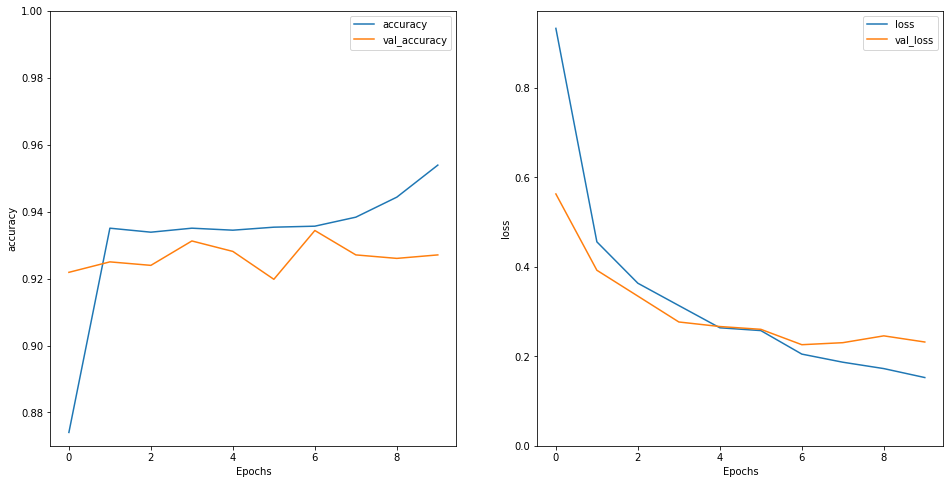

In [50]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [64]:
sample_text = [('Smartphone excelente, bom custo beneficio. '
               'Bateria dura bem e tela espetacular'),
               ('O Smartphone veio com problema. Terrível.')]
predictions = model_1.predict(np.array(sample_text))
print(predictions)

[[5.3107250e-04 9.9921942e-01 2.4959780e-04]
 [3.5847387e-01 3.1834495e-01 3.2318121e-01]]


In [76]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = model_1.predict(test_dataset)
preds = [np.argmax(y) for y in y_pred]

In [92]:
from sklearn.metrics import classification_report


print(classification_report(y_true, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.13      0.03      0.05        59
           1       0.93      0.99      0.96      1327
           2       0.00      0.00      0.00        45

    accuracy                           0.92      1431
   macro avg       0.35      0.34      0.34      1431
weighted avg       0.87      0.92      0.89      1431



## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [54]:
model_2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [55]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [56]:
history = model_2.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[callback])

Epoch 1/10
105/105 [==============================] - 26s 108ms/step - loss: 0.8548 - accuracy: 0.9084 - val_loss: 0.4144 - val_accuracy: 0.9323
Epoch 2/10
105/105 [==============================] - 7s 70ms/step - loss: 0.3765 - accuracy: 0.9354 - val_loss: 0.3424 - val_accuracy: 0.9302
Epoch 3/10
105/105 [==============================] - 7s 67ms/step - loss: 0.3303 - accuracy: 0.9354 - val_loss: 0.3045 - val_accuracy: 0.9312
Epoch 4/10
105/105 [==============================] - 7s 68ms/step - loss: 0.2854 - accuracy: 0.9354 - val_loss: 0.2847 - val_accuracy: 0.9250
Epoch 5/10
105/105 [==============================] - 7s 70ms/step - loss: 0.2320 - accuracy: 0.9357 - val_loss: 0.2492 - val_accuracy: 0.9271
Epoch 6/10
105/105 [==============================] - 7s 68ms/step - loss: 0.1856 - accuracy: 0.9387 - val_loss: 0.2408 - val_accuracy: 0.9240
Epoch 7/10
105/105 [==============================] - 7s 68ms/step - loss: 0.1574 - accuracy: 0.9458 - val_loss: 0.2497 - val_accuracy: 0.93

In [57]:
test_loss, test_acc = model_2.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

45/45 [==============================] - 2s 37ms/step - loss: 0.3053 - accuracy: 0.9322
Test Loss: 0.3053417503833771
Test Accuracy: 0.9322152137756348


In [94]:
sample_text = [('Smartphone excelente, bom custo beneficio. '
               'Bateria dura bem e tela espetacular'),
               ('O Smartphone veio com problema. Terrível.')]
predictions = model_2.predict(np.array(sample_text))
print(predictions)

[[8.2442151e-05 9.9986458e-01 5.2894571e-05]
 [3.5421458e-01 3.1483439e-01 3.3095101e-01]]


In [95]:
y_preds = model_2.predict(test_dataset)
preds = [np.argmax(y) for y in y_preds]

In [96]:
print(classification_report(y_true, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.05      0.03      0.04        59
           1       0.93      0.97      0.95      1327
           2       0.00      0.00      0.00        45

    accuracy                           0.90      1431
   macro avg       0.33      0.33      0.33      1431
weighted avg       0.86      0.90      0.88      1431



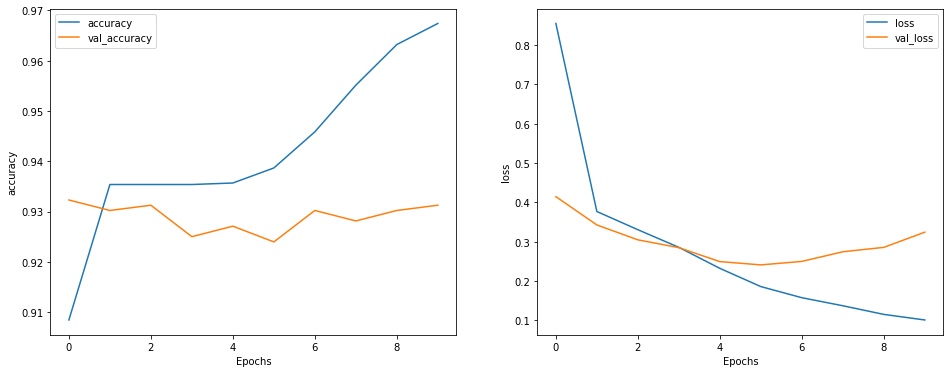

In [59]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')